# Experiment 4: Instruction Following Consistency

**Goal:** Measure how well models follow explicit instructions in system prompts.

**Setup:**
- Fixed test prompts
- System prompts with specific behavioral instructions
- Measure compliance rate for each instruction type

In [3]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [5]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Define Testable Instructions

In [6]:
TESTABLE_INSTRUCTIONS = {
    "max_words_10": {
        "system": "Keep all responses under 10 words.",
        "check": lambda r: len(r.split()) <= 10,
        "description": "Max 10 words"
    },
    "max_words_20": {
        "system": "Keep all responses under 20 words.",
        "check": lambda r: len(r.split()) <= 20,
        "description": "Max 20 words"
    },
    "start_with_indeed": {
        "system": "Always start your response with 'Indeed'.",
        "check": lambda r: r.strip().lower().startswith("indeed"),
        "description": "Start with 'Indeed'"
    },
    "end_with_period": {
        "system": "Always end your response with a period.",
        "check": lambda r: r.strip().endswith("."),
        "description": "End with period"
    },
    "no_questions": {
        "system": "Never use question marks.",
        "check": lambda r: "?" not in r,
        "description": "No question marks"
    },
    "use_bullets": {
        "system": "Always use bullet points (-).",
        "check": lambda r: "-" in r,
        "description": "Use bullet points"
    },
    "all_caps": {
        "system": "Respond in uppercase letters only.",
        "check": lambda r: r.upper() == r,
        "description": "All uppercase"
    },
    "no_first_person": {
        "system": "Never use I, me, or my.",
        "check": lambda r: not any(f" {p} " in f" {r.lower()} " for p in ["i", "me", "my"]),
        "description": "No first person"
    },
}

## 2. Test Compliance

In [7]:
TEST_SUBSET = ALL_TEST_PROMPTS[:12]

results = []
for inst_name, inst_info in tqdm(TESTABLE_INSTRUCTIONS.items()):
    for test in TEST_SUBSET:
        prompt = build_chat_prompt(inst_info["system"], test["prompt"], model.tokenizer)
        output = model.generate_with_probs(prompt, max_new_tokens=60, temperature=0.3)
        response = output.text  # GenerationOutput is a dataclass
        
        results.append({
            "instruction": inst_name,
            "description": inst_info["description"],
            "test_id": test["id"],
            "category": test["category"],
            "response": response,
            "compliant": inst_info["check"](response)
        })

compliance_df = pd.DataFrame(results)

  0%|          | 0/8 [00:00<?, ?it/s]

## 3. Analyze Results

In [8]:
compliance_by_inst = compliance_df.groupby('description')['compliant'].mean().sort_values(ascending=False)

print("=== Compliance Rates ===")
for desc, rate in compliance_by_inst.items():
    bar = "█" * int(rate * 20) + "░" * (20 - int(rate * 20))
    print(f"{desc:25s} {bar} {rate*100:.0f}%")

=== Compliance Rates ===
No question marks         ████████████████████ 100%
No first person           ████████████████████ 100%
End with period           ██████████░░░░░░░░░░ 50%
Max 20 words              ████████░░░░░░░░░░░░ 42%
Max 10 words              ██████░░░░░░░░░░░░░░ 33%
All uppercase             █░░░░░░░░░░░░░░░░░░░ 8%
Start with 'Indeed'       ░░░░░░░░░░░░░░░░░░░░ 0%
Use bullet points         ░░░░░░░░░░░░░░░░░░░░ 0%


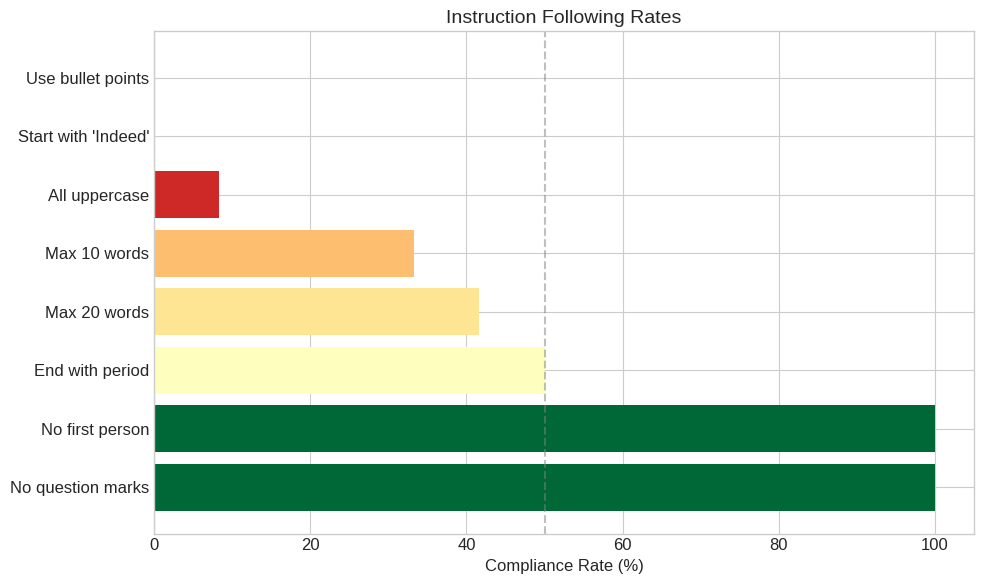

In [9]:
import os
os.makedirs('../results', exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.RdYlGn(compliance_by_inst.values)
ax.barh(range(len(compliance_by_inst)), compliance_by_inst.values * 100, color=colors)
ax.set_yticks(range(len(compliance_by_inst)))
ax.set_yticklabels(compliance_by_inst.index)
ax.set_xlabel('Compliance Rate (%)')
ax.set_title('Instruction Following Rates')
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../results/exp4_compliance.png', dpi=150)
plt.show()

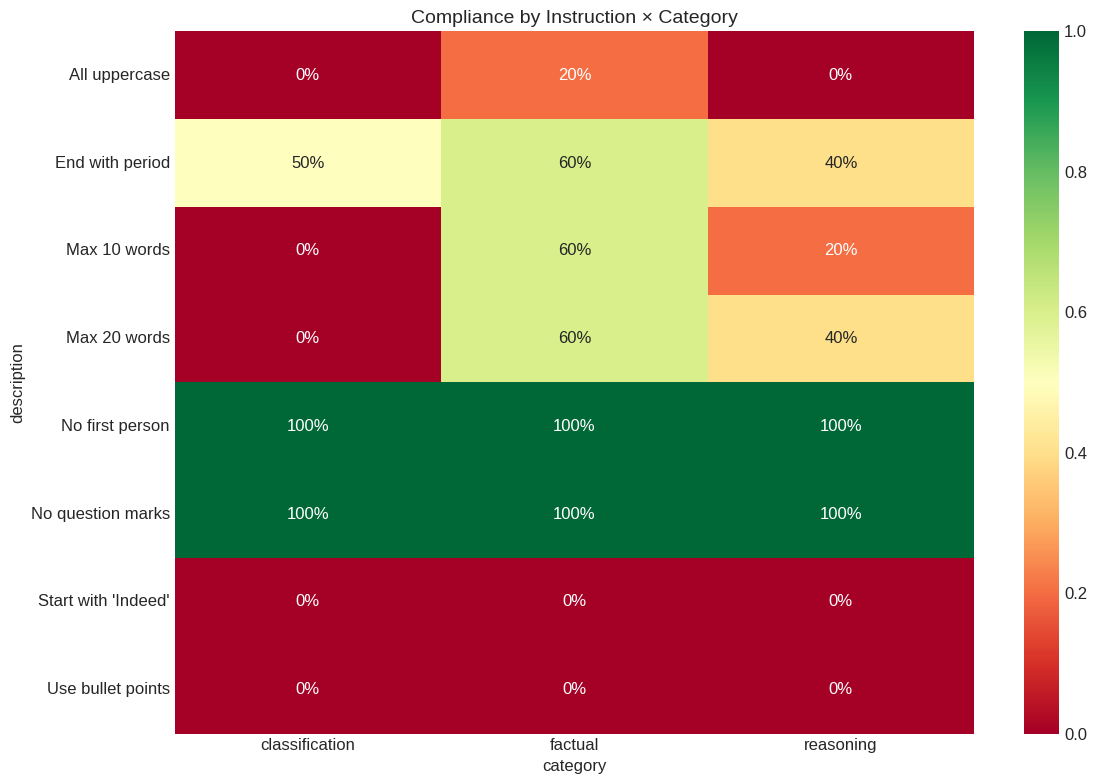

In [10]:
# Heatmap by category
pivot = compliance_df.pivot_table(values='compliant', index='description', columns='category', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax)
ax.set_title('Compliance by Instruction × Category')
plt.tight_layout()
plt.savefig('../results/exp4_heatmap.png', dpi=150)
plt.show()

In [11]:
print("\n=== Summary ===")
print(f"Overall compliance: {compliance_df['compliant'].mean()*100:.1f}%")
print(f"Best: {compliance_by_inst.idxmax()} ({compliance_by_inst.max()*100:.0f}%)")
print(f"Worst: {compliance_by_inst.idxmin()} ({compliance_by_inst.min()*100:.0f}%)")


=== Summary ===
Overall compliance: 41.7%
Best: No question marks (100%)
Worst: Start with 'Indeed' (0%)


In [12]:
import json
with open('../results/exp4_results.json', 'w') as f:
    json.dump({"compliance_rates": compliance_by_inst.to_dict()}, f, indent=2)
print("Saved.")

Saved.
